# Формат JPEG

Рассмотрим первые два шага работы алгоритма JPEG.

Подгрузим необходимые пакеты, а также таблицу для квантования значения.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import img_as_ubyte, img_as_float
from skimage import color
from scipy import fftpack



std_quant_tbl = np.array(
[ 16,  11,  10,  16,  24,  40,  51,  61,
  12,  12,  14,  19,  26,  58,  60,  55,
  14,  13,  16,  24,  40,  57,  69,  56,
  14,  17,  22,  29,  51,  87,  80,  62,
  18,  22,  37,  56,  68, 109, 103,  77,
  24,  35,  55,  64,  81, 104, 113,  92,
  49,  64,  78,  87, 103, 121, 120, 101,
  72,  92,  95,  98, 112, 100, 103,  99],dtype=int)

Загрузим серое изображение и переведём его в формат, где пиксели принимают значения от 0 до 255, с помощью метода `img_as_ubyte()`

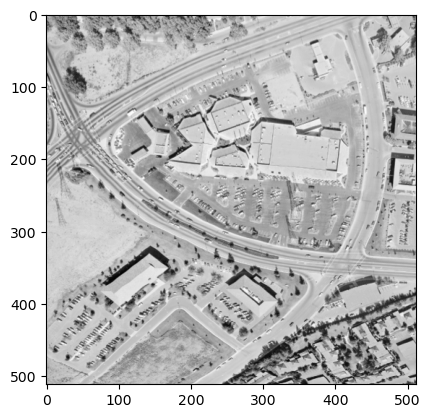

In [2]:
im_src = img_as_ubyte(plt.imread('source/arial_image.png'))
plt.imshow(im_src, cmap='gray')

In [3]:
im_src.shape

(512, 512)

Сделаем предобработку, чтобы размеры изображения были кратны 8. При необходимости, дополним изображение нулями методом `np.pad()`

In [4]:
height_src, width_src = im_src.shape

# сделать размер изображения кратным 8
im_width = width_src
im_height = height_src
if (width_src % 8 != 0):
    im_width = width_src // 8 * 8 + 8
if (height_src % 8 != 0):
    im_height = height_src // 8 * 8 + 8

# дополнить нулями, если требуется
im = np.pad(im_src, ((0,im_height-height_src),(0,im_width-width_src)))
# вычесть 128, сначала приведя формат к целым 
im = np.int16(im) - 128
im

array([[127, 127, 127, ..., 127, 127, 127],
       [ 70,  74,  64, ...,  35,  22,   2],
       [ 54,  75,  67, ...,   9,  28,  30],
       ...,
       [ 46,  25,  59, ...,  -5, -71, -75],
       [ 45,  51,  41, ..., -20, -30, -55],
       [ 43,  49,  50, ...,   3,  -3, -23]], dtype=int16)

Далее, реализуем метод для квантования коэффициентов. Первый метод `getQuantTable()` считает матрицу для квантования, согласно выбранному качеству. Второй метод `BlockQuantization()` прозводит квантование.

In [5]:
def getQuantTable(quality): 
    if(quality <= 0):
        quality = 1
    if(quality > 100):
        quality = 100
    if(quality < 50):
        qualityScale = 5000 / quality
    else:
        qualityScale = 200 - quality * 2

    QuantTbl = np.array(np.floor((std_quant_tbl * qualityScale + 50) / 100))
    QuantTbl[QuantTbl == 0] = 1
    QuantTbl[QuantTbl > 255] = 255
    QuantTbl = QuantTbl.reshape([8, 8]).astype(int)
    return QuantTbl

def BlockQuantization(block, QuantTbl):
    return np.rint(block / QuantTbl)

In [10]:
quality = 50
QuantTbl = getQuantTable(quality)
print('Таблица квантования:\n', QuantTbl)

Таблица квантования:
 [[ 16  11  10  16  24  40  51  61]
 [ 12  12  14  19  26  58  60  55]
 [ 14  13  16  24  40  57  69  56]
 [ 14  17  22  29  51  87  80  62]
 [ 18  22  37  56  68 109 103  77]
 [ 24  35  55  64  81 104 113  92]
 [ 49  64  78  87 103 121 120 101]
 [ 72  92  95  98 112 100 103  99]]


Осталось собрать все проделанные шаги в один метод, которые по серому изображению проделывает 2 шага из алгоритма JPEG

In [11]:
def ImageCompress(im_src, quality = 50):
    height_src, width_src = im_src.shape
    # сделать размер изображения кратным 8
    im_width = width_src
    im_height = height_src
    if (width_src % 8 != 0):
        im_width = width_src // 8 * 8 + 8
    if (height_src % 8 != 0):
        im_height = height_src // 8 * 8 + 8

    # дополнить нулями, если требуется, сменить тип, поскольку дальше вычитание значения и прочие вычисления
    im = np.pad(im_src, ((0,im_height-height_src),(0,im_width-width_src)))
    im = np.int16(im) - 128
    
    # создать таблица квантования по качеству
    QuantTbl = getQuantTable(quality)
    im_dct_quant = np.zeros((im_height, im_width))

    # цикл по блокам
    for y in range(0, im_height, 8):
        for x in range(0, im_width, 8):
            # DCT для блока
            block = fftpack.dctn(im[y:y + 8, x:x + 8], norm='ortho')
            # квантование блока
            block = BlockQuantization(block, QuantTbl)
            im_dct_quant[y:y + 8, x:x + 8] = block
    return im_dct_quant

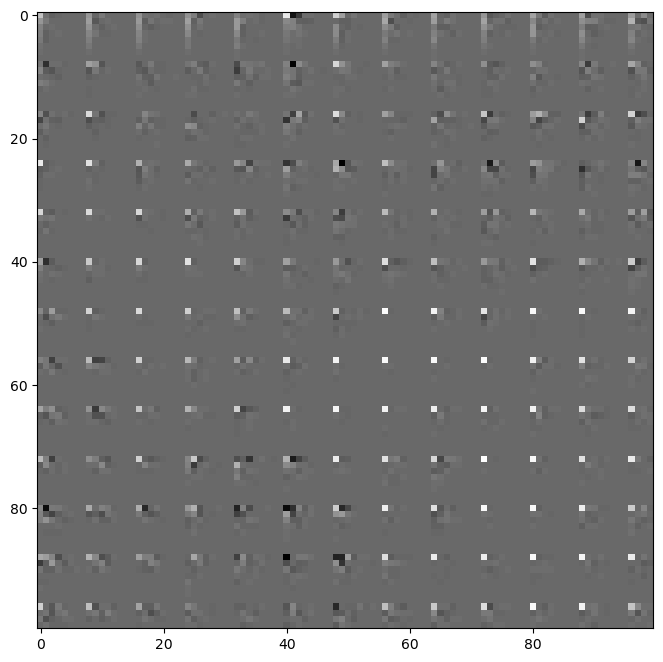

In [12]:
im_dct  = ImageCompress(im_src,50)
plt.figure(figsize=(8, 8))
plt.imshow(im_dct[0:100,0:100], cmap='gray')

Далее, напишем код для восстановления изображения по квантованным коэффициентам.

In [13]:
def ImageDecompress(im_dct_quant, quality = 50):
    im_height, im_width = im_dct_quant.shape  

    QuantTbl = getQuantTable(quality)
    im = np.zeros((im_height, im_width))

    for y in range(0, im_height, 8):
        for x in range(0, im_width, 8):
            block = im_dct_quant[y:y + 8, x:x + 8]*QuantTbl
            block = fftpack.idctn(block, norm='ortho')
            im[y:y + 8, x:x + 8] = block
    im = im + 128
    return im.clip(min=0, max=255).round().astype(np.uint8)

Проверим работу на найденных коэффициентах для исходного изображения.

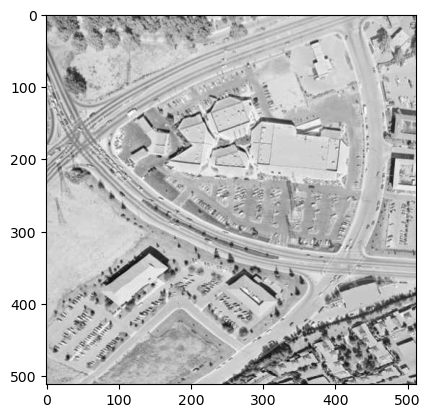

In [14]:
im_dec = ImageDecompress(im_dct,50)
plt.imshow(im_dec, cmap='gray')

Следующий код позволяет найти число нулей среди полученных коэффициентов.

In [15]:
quality = [1,10,50,75,90,100]
for q in quality:
    im_dct = ImageCompress(im_src,q)
    unique, counts = np.unique(im_dct.astype(np.int16), return_counts=True)
    zeros = dict(zip(unique, counts))[0]/512**2
    print('Качество:'+str(q)+'%, доля нулей: '+ str(zeros))

Качество:1%, доля нулей: 0.9766960144042969
Качество:10%, доля нулей: 0.9207191467285156
Качество:50%, доля нулей: 0.7836151123046875
Качество:75%, доля нулей: 0.6984748840332031
Качество:90%, доля нулей: 0.5445823669433594
Качество:100%, доля нулей: 0.1002197265625


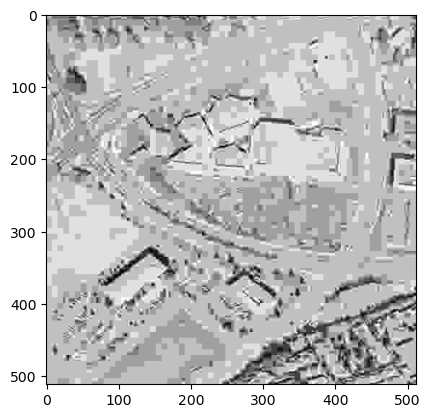

In [18]:
qual = 1
im_dec = ImageDecompress(ImageCompress(im_src,qual),qual)
plt.imshow(im_dec, cmap='gray')

Классической метрикой для измерения шума в изображениях является PSNR (Peak Signal-To-Noise Ratio). Это соотношение между максимумом возможного значения сигнала и мощностью шума, искажающего значения сигнала. Поскольку многие сигналы имеют широкий динамический диапазон, PSNR обычно измеряется в логарифмической шкале в децибелах. 

$$
PSNR_{db} = 20 \log_{10} \left( \frac{MAX_{sig}}{RMSE}\right),
$$

где $MAX_{sig}$ в нашем случае равно 255, а RMSE

$$
RMSE = \sqrt{\frac{1}{N M} \sum_{i=1}^N \sum_{j=1}^M |I_{orig}(i,j) - I_{noised}(i,j)|^2}
$$

In [19]:
from skimage.metrics import peak_signal_noise_ratio 

peak_signal_noise_ratio(im_src, im_dec)

20.838188905047666

Будет также вычислять SNR и сравним эти значения для различных степеней качества:

In [21]:
def mySNR(sig,noise):
    return 10*np.log10(np.sum(np.abs(sig)**2)/np.sum(np.abs(noise)**2))

In [22]:
quality = [1,10,50,75,90,100]
for q in quality:
    im_dec = ImageDecompress(ImageCompress(im_src,q),q)
    print('PSNR: '+str(peak_signal_noise_ratio(im_src, im_dec))+', SNR: '+ str(mySNR(im_src,im_src-im_dec)))

PSNR: 20.838188905047666, SNR: 1.0661199157704164
PSNR: 25.895116440061244, SNR: 2.7888433666609664
PSNR: 31.41555288642264, SNR: 5.4444355678283
PSNR: 34.1153953586689, SNR: 7.113536074160031
PSNR: 38.930199778833575, SNR: 11.39065258938896
PSNR: 58.907995461636524, SNR: 31.36538822435695


In [23]:
def plot_comparison(img_original, img_filtered, img_title_filtered, figsize=(16, 14)):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=figsize, sharex=True, sharey=True)
    ax1.imshow(img_original, cmap=plt.cm.gray)
    ax1.set_title('Оригинал')
    ax1.axis('off')
    ax2.imshow(img_filtered, cmap=plt.cm.gray)
    ax2.set_title(img_title_filtered)
    ax2.axis('off')

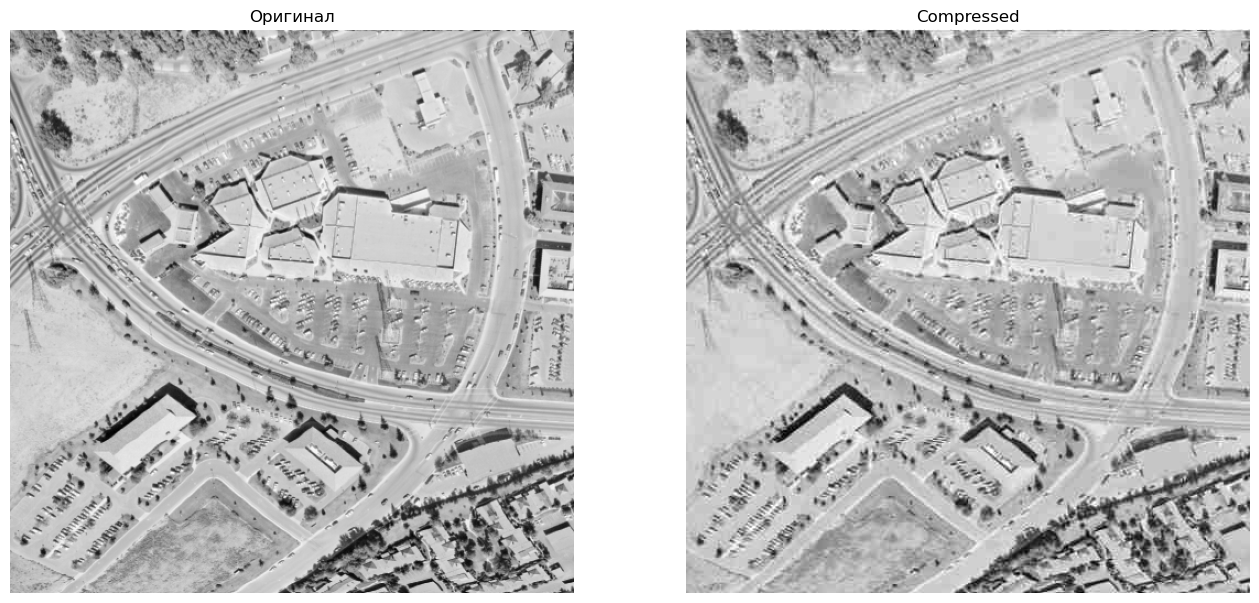

In [25]:
q=20
im_dec = ImageDecompress(ImageCompress(im_src,q),q)
plot_comparison(im_src,im_dec,"Compressed")

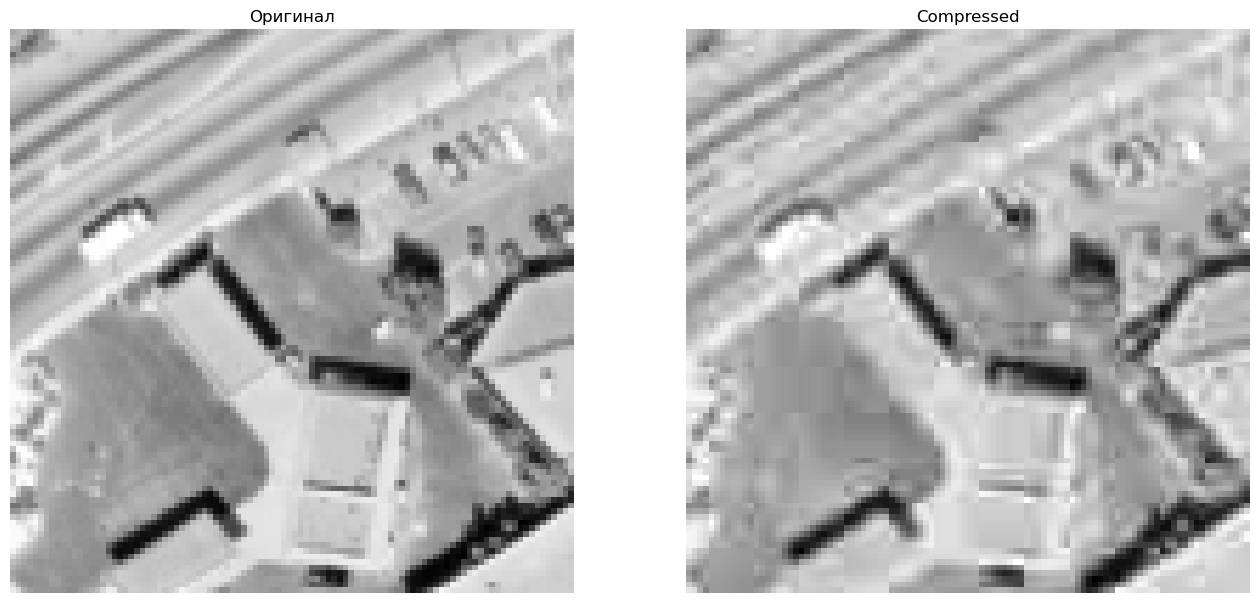

In [26]:
plot_comparison(im_src[100:200,100:200],im_dec[100:200,100:200],"Compressed")

In [ ]:
zigzagOrder = np.array([0,1,8,16,9,2,3,10,17,24,32,25,18,11,4,5,12,19,26,33,40,48,41,34,27,20,13,6,7,14,21,28,35,42,
                           49,56,57,50,43,36,29,22,15,23,30,37,44,51,58,59,52,45,38,31,39,46,53,60,61,54,47,55,62,63])